# do some stuffs for cifar dataset

## gen data

In [1]:
from src.data.gen_cifar import gen_cifar
gen_cifar('./data/cifar/')


=========== Generating data ===========

Create training data

ReDivide: 75% training data, 25% testing data
Files already downloaded and verified
Files already downloaded and verified
(45000, 3072) (45000,)
(15000, 3072) (15000,)

Num sample of client in each label
[2010, 563, 715, 481, 90, 291, 55, 33, 114, 167]
[1411, 1013, 414, 761, 302, 67, 62, 210, 109, 165]
[459, 723, 1154, 291, 541, 398, 398, 259, 96, 231]
[1547, 1104, 830, 205, 137, 207, 68, 171, 32, 179]
[684, 375, 1497, 606, 196, 543, 232, 94, 60, 182]
[890, 1009, 450, 757, 291, 134, 178, 411, 71, 363]
[1748, 1152, 297, 346, 321, 105, 70, 75, 68, 260]
[699, 484, 1013, 397, 405, 587, 393, 157, 91, 269]
[1989, 730, 582, 414, 299, 74, 141, 124, 73, 120]
[1180, 499, 1112, 153, 592, 308, 203, 46, 61, 277]

Create testing data

Num sample of client in each label
[564, 290, 220, 124, 137, 146]
[333, 417, 128, 85, 159, 364]
[590, 313, 263, 55, 32, 197]
[525, 357, 220, 205, 40, 173]
[592, 157, 218, 107, 53, 404]
[604, 404, 133, 58, 

## vis

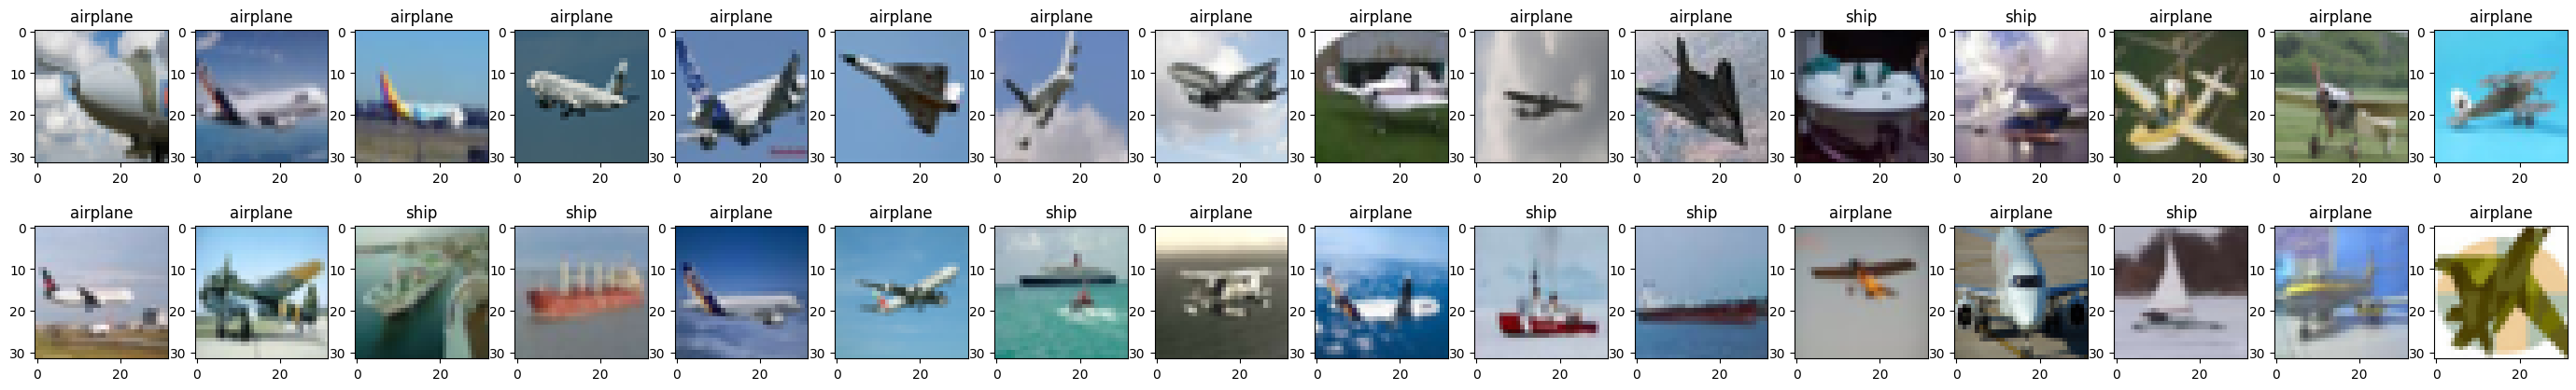

In [2]:
from src.data.cifar_loader import get_loader
import matplotlib.pyplot as plt

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axs = plt.subplots(nrows=2, ncols=16, figsize=(35,5))
count = 0
fig.subplots_adjust(hspace=0.2)

loader = get_loader('./data/cifar/client_test/3_q.json')
for batch in loader:
    for x, y in zip(batch[0], batch[1]):
        axs.flat[count].imshow(x.reshape(32,32,3), cmap='gray')
        axs.flat[count].set_title(labels[int(y)])
        count += 1
    break

## distribution of data in clients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [4]:
def draw_distribution(data, axis, filename):
    profile = np.zeros((10,2))
    profile[:,0] = range(10)
    for key in data.keys():
        profile[int(key),1] = len(data[key])
    axis.bar(x=profile[:,0], height=profile[:,1])
    # axis.set_title(list(data.keys()))
    # axis.set_title(filename)
    axis.set_title(profile[:,1][profile[:,1]!=0])

/Users/nguyenbaolong/miniconda3/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


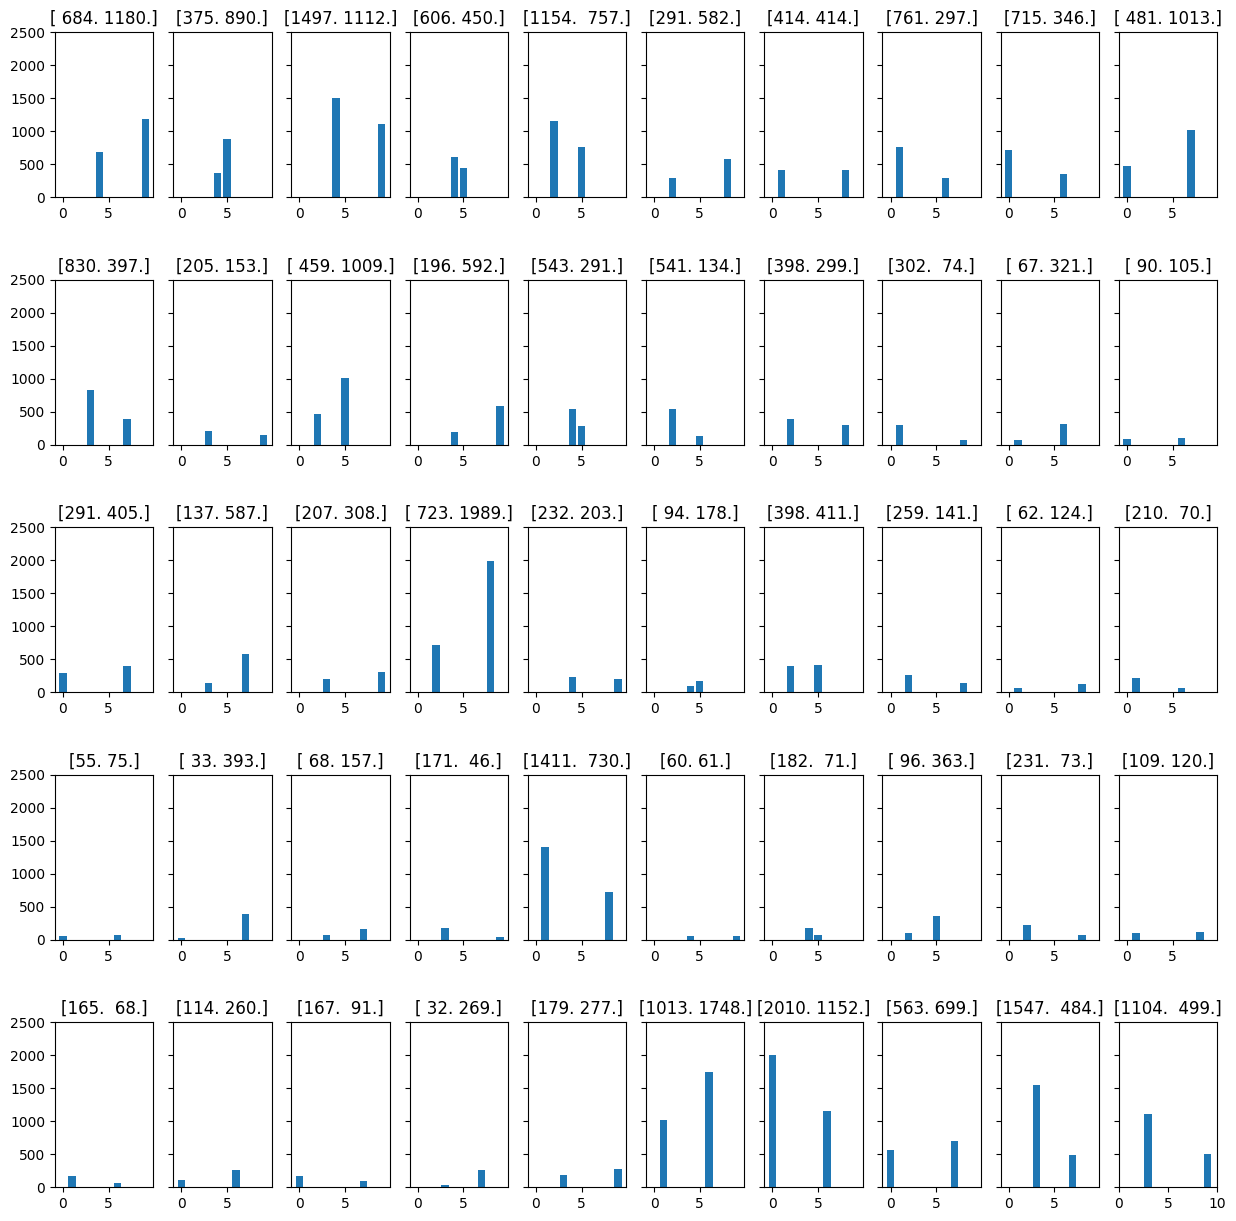

In [5]:
dir = './data/cifar/client_train/'
fig, axis = plt.subplots(nrows=5, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 2500])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

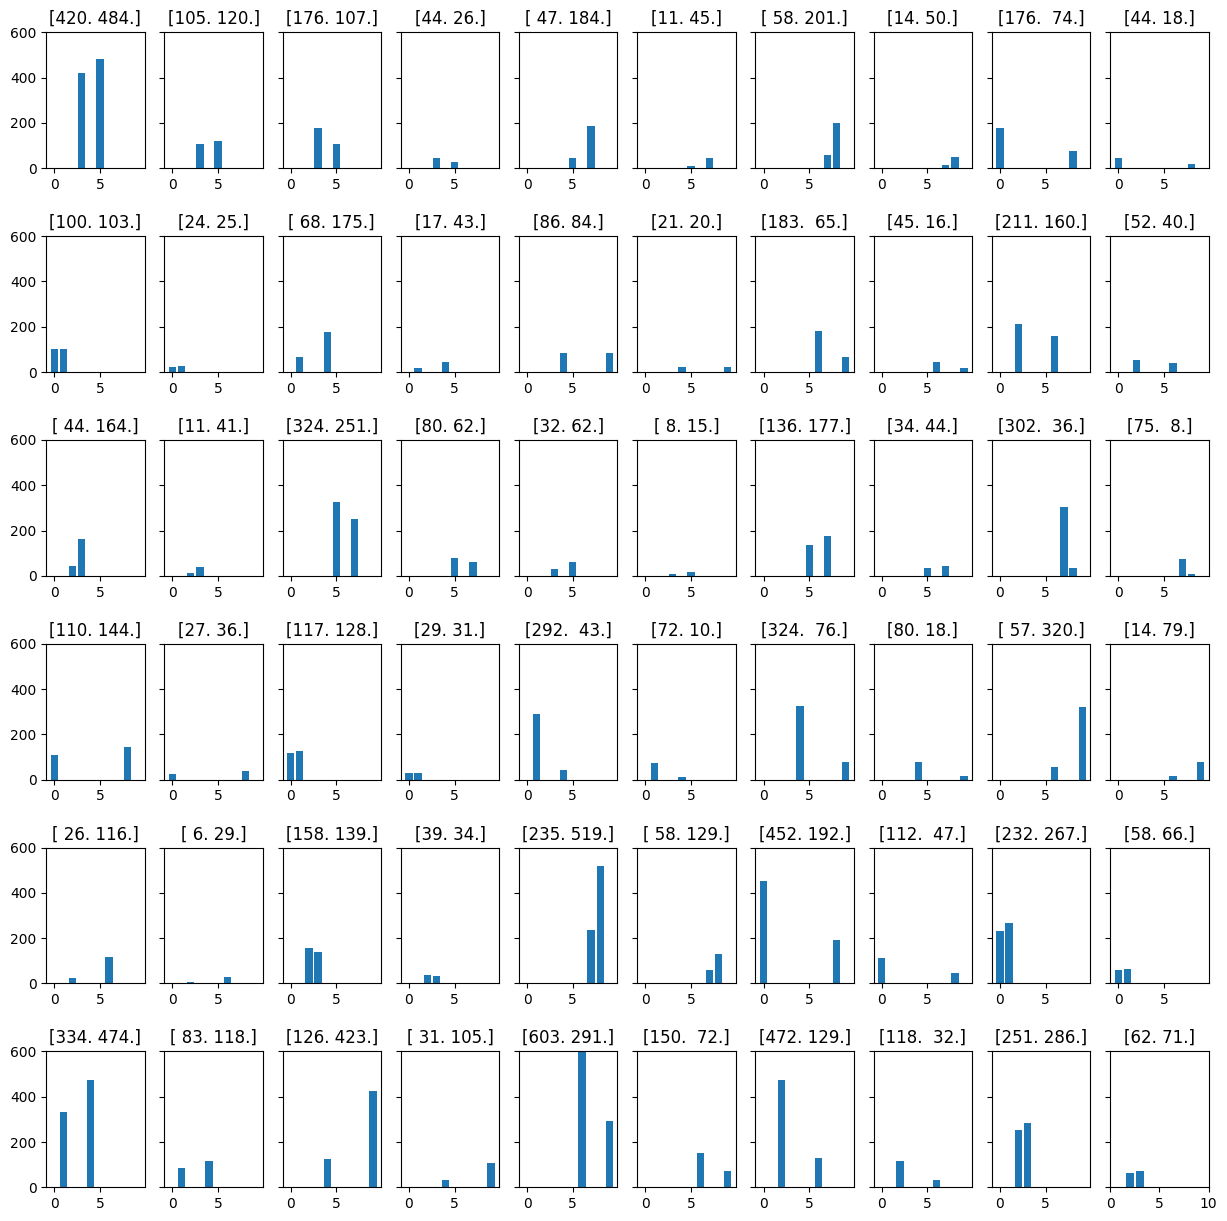

In [6]:
dir = './data/cifar/client_test/'
fig, axis = plt.subplots(nrows=6, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 600])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

## test model

In [7]:
import torch
from torch import nn
from src.model.cifar_model import Cifar
from src.data.cifar_loader import get_loader

In [8]:
# data
train_loader = get_loader('./data/cifar/client_test/0_s.json')
test_loader = get_loader('./data/cifar/client_test/0_q.json')

In [9]:
# train
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return train_loss, correct/size

In [10]:
# test
def test(dataloader, model, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

In [11]:
# device
device = torch.device('cpu')
print(f'Using {device}')

Using cpu


In [12]:
# model
model = Cifar().to(device)
print(model)

# opt
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Cifar(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
%%time

# use cpu
epochs = 15
for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    print(f"Epoch {t+1}: Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    if t == 0 or (t+1) % 5 == 0:
        test_loss, test_acc = test(test_loader, model, device)
        print(f"[Test] Epoch {t+1}:\n\tAccuracy: {(100*test_acc):>0.1f}%, Loss: {test_loss:>8f} \n")
print("Done!")

Epoch 1: Accuracy: 40.9%, Loss: 1.306274
[Test] Epoch 1:
	Accuracy: 46.5%, Loss: 0.038449 

Epoch 2: Accuracy: 48.9%, Loss: 1.878649
Epoch 3: Accuracy: 49.3%, Loss: 1.061871
Epoch 4: Accuracy: 53.8%, Loss: 0.358960
Epoch 5: Accuracy: 53.3%, Loss: 0.816444
[Test] Epoch 5:
	Accuracy: 46.5%, Loss: 0.022481 

Epoch 6: Accuracy: 46.7%, Loss: 0.948128
Epoch 7: Accuracy: 49.3%, Loss: 0.927063
Epoch 8: Accuracy: 53.3%, Loss: 0.530735
Epoch 9: Accuracy: 53.3%, Loss: 0.807050
Epoch 10: Accuracy: 46.7%, Loss: 0.554265
[Test] Epoch 10:
	Accuracy: 46.5%, Loss: 0.023433 

Epoch 11: Accuracy: 46.7%, Loss: 0.718368
Epoch 12: Accuracy: 53.3%, Loss: 0.421138
Epoch 13: Accuracy: 53.3%, Loss: 0.598234
Epoch 14: Accuracy: 53.3%, Loss: 0.650877
Epoch 15: Accuracy: 53.3%, Loss: 0.487525
[Test] Epoch 15:
	Accuracy: 53.5%, Loss: 0.022755 

Done!
CPU times: user 1.69 s, sys: 659 ms, total: 2.35 s
Wall time: 1.3 s


# do some stuffs for mnist dataset

## test gen data mnist

In [14]:
from src.data.gen_mnist import gen_mnist
gen_mnist('./data/mnist/')


=========== Generating data ===========

Create training data

ReDivide: 75% training data, 25% testing data
(52500, 784) (52500,)
(17500, 784) (17500,)

Num sample of client in each label
[586, 1947, 327, 451, 287, 746, 301, 219, 47, 241]
[880, 842, 806, 807, 627, 360, 460, 140, 123, 872]
[933, 1137, 1492, 775, 317, 239, 161, 55, 40, 71]
[1423, 834, 842, 820, 515, 138, 312, 164, 106, 162]
[549, 1977, 856, 436, 205, 219, 173, 307, 119, 305]
[500, 469, 1273, 805, 511, 540, 148, 71, 44, 330]
[813, 1076, 785, 1107, 430, 334, 210, 113, 143, 188]
[2557, 679, 341, 235, 599, 120, 357, 86, 164, 353]
[2256, 639, 1060, 471, 260, 158, 32, 101, 22, 117]
[1412, 1692, 654, 347, 545, 300, 38, 105, 69, 90]

Create testing data

Num sample of client in each label
[163, 340, 611, 185, 94, 358]
[929, 412, 219, 100, 76, 224]
[719, 143, 342, 206, 128, 232]
[345, 708, 274, 57, 216, 225]
[612, 346, 143, 226, 135, 216]
[587, 478, 141, 40, 43, 333]
[242, 311, 103, 186, 258, 577]
[242, 300, 546, 149, 255, 310]

## visualize distribution of clients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
def draw_distribution(data, axis, filename):
    profile = np.zeros((10,2))
    profile[:,0] = range(10)
    for key in data.keys():
        profile[int(key),1] = len(data[key])
    axis.bar(x=profile[:,0], height=profile[:,1])
    # axis.set_title(list(data.keys()))
    # axis.set_title(filename)
    axis.set_title(profile[:,1][profile[:,1]!=0])

/Users/nguyenbaolong/miniconda3/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


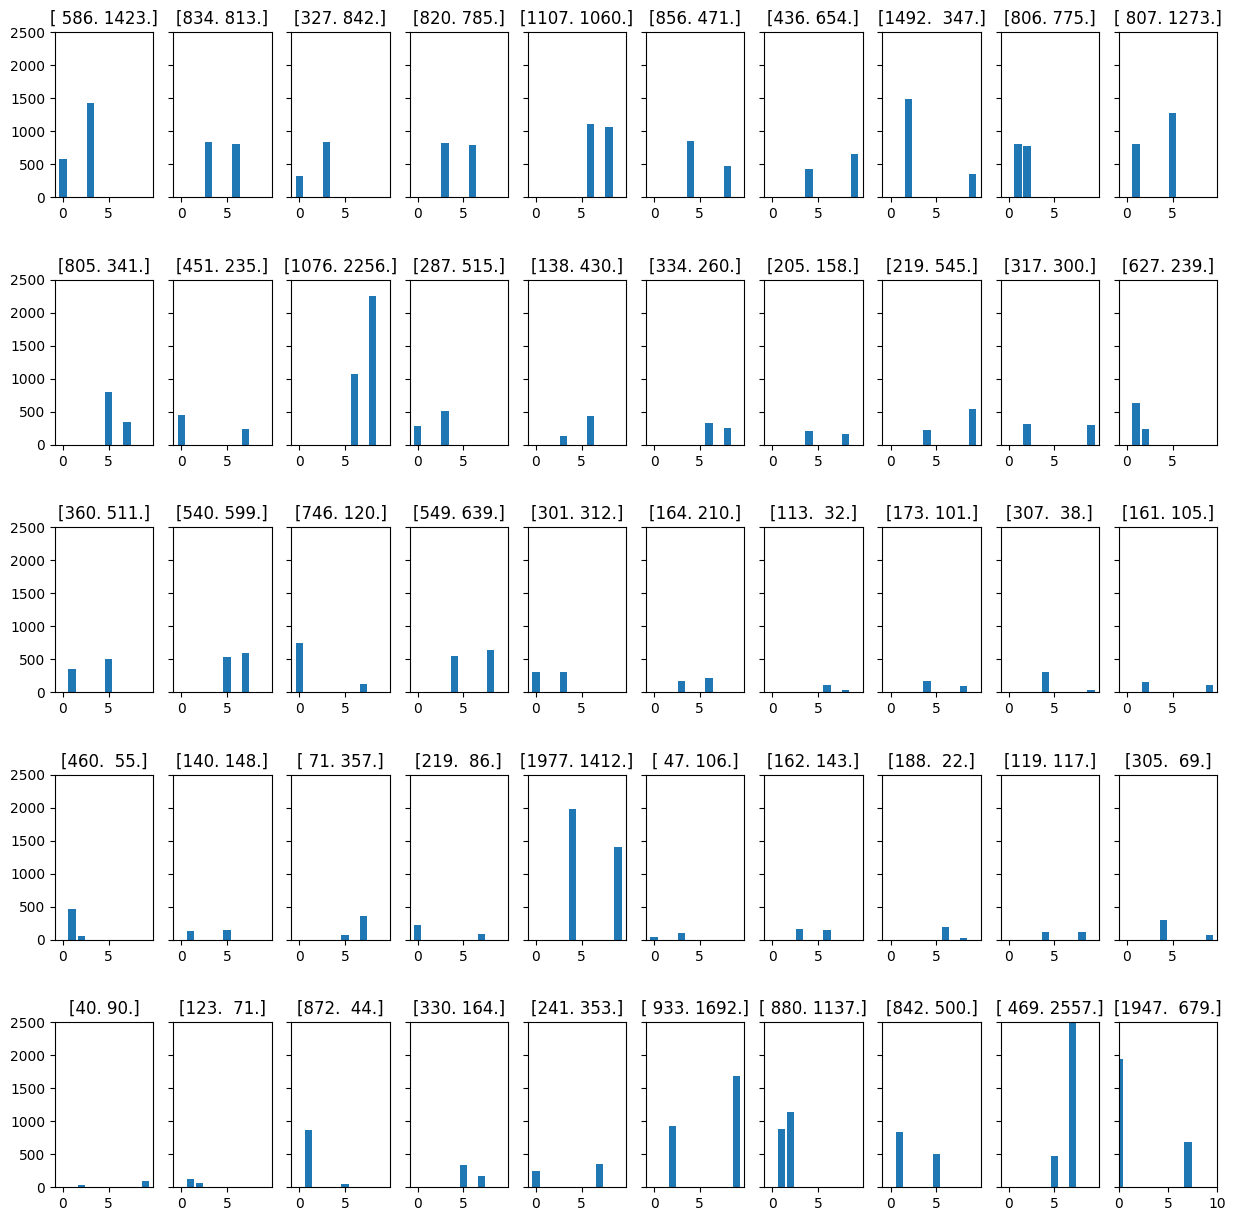

In [3]:
dir = './data/mnist/client_train/'
fig, axis = plt.subplots(nrows=5, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 2500])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

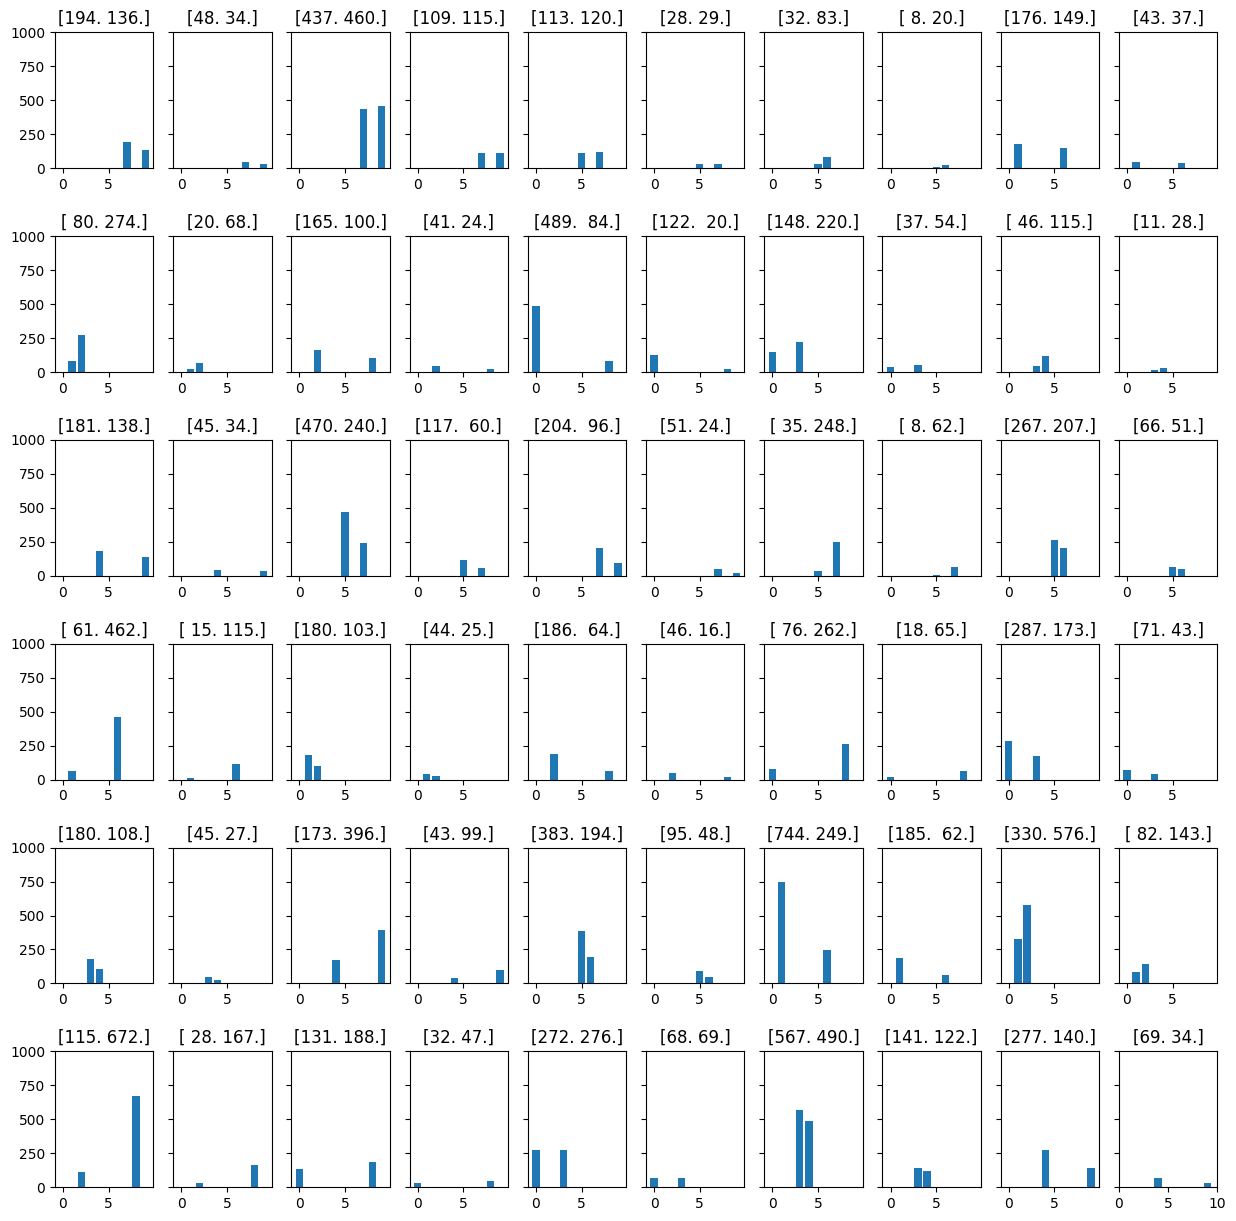

In [4]:
dir = './data/mnist/client_test/'
fig, axis = plt.subplots(nrows=6, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 1000])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

---

## test mnist loader

In [5]:
from src.data.mnist_loader import get_loader
import matplotlib.pyplot as plt

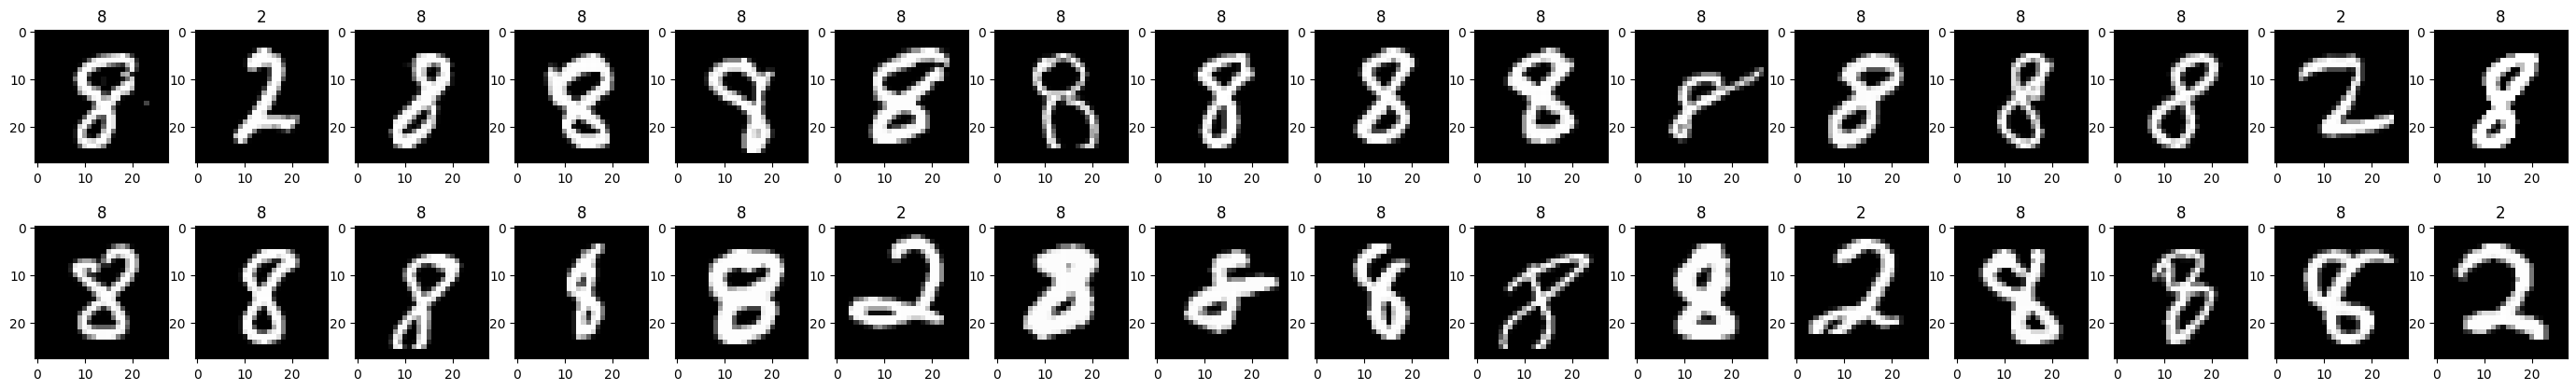

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=16, figsize=(35,5))
count = 0
fig.subplots_adjust(hspace=0.2)

loader = get_loader('./data/mnist/client_test/5_q.json')
for batch in loader:
    for x, y in zip(batch[0], batch[1]):
        axs.flat[count].imshow(x.reshape((28,28)), cmap='gray')
        axs.flat[count].set_title(int(y))
        count += 1
    break

---

## test loss function

In [11]:
import torch
from torch import nn
from src.model.mnist_model import Mnist
from src.data.mnist_loader import get_loader

In [12]:
model = Mnist()
loader = get_loader('./data/mnist/client_test/0_q.json')

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
for X, y in loader:
    print(X.size(), y.size())
    pred = model(X)
    print(pred.size())
    loss = loss_fn(pred, y)
    print(loss.item())
    break

torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 10])
2.3902578353881836


## test model mnist (centralized)

In [14]:
import torch
from torch import nn
from src.model.mnist_model import Mnist
from src.data.mnist_loader import get_loader

In [15]:
# data
train_loader = get_loader('./data/mnist/client_test/0_s.json')
test_loader = get_loader('./data/mnist/client_test/0_q.json')

In [16]:
# train
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return train_loss, correct/size

In [17]:
# test
def test(dataloader, model, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

In [18]:
%%time

# device
device = torch.device('mps')
print(f'Using {device}')

# model
model = Mnist().to(device)
print(model)

# opt
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# use mps
epochs = 15
for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    print(f"Epoch {t+1}: Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    if t == 0 or (t+1) % 5 == 0:
        test_loss, test_acc = test(test_loader, model, device)
        print(f"[Test] Epoch {t+1}:\n\tAccuracy: {(100*test_acc):>0.1f}%, Loss: {test_loss:>8f} \n")
print("Done!")

Using mps
Mnist(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Epoch 1: Accuracy: 0.0%, Loss: 2.322986
[Test] Epoch 1:
	Accuracy: 0.6%, Loss: 0.076900 

Epoch 2: Accuracy: 0.0%, Loss: 2.300004
Epoch 3: Accuracy: 0.0%, Loss: 2.261549
Epoch 4: Accuracy: 1.2%, Loss: 2.283156
Epoch 5: Accuracy: 3.7%, Loss: 2.263054
[Test] Epoch 5:
	Accuracy: 3.9%, Loss: 0.075650 

Epoch 6: Accuracy: 8.5%, Loss: 2.250489
Epoch 7: Accuracy: 14.6%, Loss: 2.262792
Epoch 8: Accuracy: 19.5%, Loss: 2.274169
Epoch 9: Accuracy: 20.7%, Loss: 2.228235
Epoch 10: Accuracy: 25.6%, Loss: 2.218904
[Test] Epoch 10:
	Accuracy: 24.8%, Loss: 0.074321 

Epoch 11: Accuracy: 25.6%, Loss: 2.209915
Epoch 12: Accuracy: 26.8%, Loss: 2.231282
Epoch 13: Accuracy: 31.7%, Loss: 2.156342
Epoch 14: Accuracy: 35.4%, Loss: 2.185777
Epoch 15: Accuracy: 39.0%, Loss: 2.189921
[Test] Epoch 15:
	Accuracy: 42.1%, Loss: 0.072654 

Done!
CPU times: user 252 ms, sys: 112 

In [19]:
%%time

# device
device = torch.device('cpu')
print(f'Using {device}')

# model
model = Mnist().to(device)
print(model)

# opt
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# use cpu
epochs = 15
for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    print(f"Epoch {t+1}: Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    if t == 0 or (t+1) % 5 == 0:
        test_loss, test_acc = test(test_loader, model, device)
        print(f"[Test] Epoch {t+1}:\n\tAccuracy: {(100*test_acc):>0.1f}%, Loss: {test_loss:>8f} \n")
print("Done!")

Using cpu
Mnist(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Epoch 1: Accuracy: 0.0%, Loss: 2.357055
[Test] Epoch 1:
	Accuracy: 0.0%, Loss: 0.078816 

Epoch 2: Accuracy: 0.0%, Loss: 2.347618
Epoch 3: Accuracy: 0.0%, Loss: 2.356486
Epoch 4: Accuracy: 0.0%, Loss: 2.352734
Epoch 5: Accuracy: 0.0%, Loss: 2.329305
[Test] Epoch 5:
	Accuracy: 0.0%, Loss: 0.077657 

Epoch 6: Accuracy: 0.0%, Loss: 2.294291
Epoch 7: Accuracy: 1.2%, Loss: 2.317850
Epoch 8: Accuracy: 3.7%, Loss: 2.293500
Epoch 9: Accuracy: 3.7%, Loss: 2.300553
Epoch 10: Accuracy: 6.1%, Loss: 2.288414
[Test] Epoch 10:
	Accuracy: 7.0%, Loss: 0.076198 

Epoch 11: Accuracy: 6.1%, Loss: 2.275997
Epoch 12: Accuracy: 11.0%, Loss: 2.273308
Epoch 13: Accuracy: 14.6%, Loss: 2.264940
Epoch 14: Accuracy: 19.5%, Loss: 2.241935
Epoch 15: Accuracy: 23.2%, Loss: 2.255439
[Test] Epoch 15:
	Accuracy: 26.7%, Loss: 0.074785 

Done!
CPU times: user 58.7 ms, sys: 16.4 ms, 

## model param

In [1]:
import torch
from torch import nn
from src.model.mnist_model import Mnist

In [2]:
model = Mnist()
model.parameters()

<generator object Module.parameters at 0x14666b5a0>

In [3]:
for p in model.parameters():
    p.data = torch.ones_like(p)
#     print(type(p.data))

for p in model.parameters():
    print(p)

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 

In [11]:
a = torch.Tensor([1,2,3])
b = a.clone()
id(a), id(b)

(4527462960, 4530756864)

# visualize train_log & test_log

In [1]:
import plotly.graph_objects as go
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
dir = './experiment/2023-03-22/11:19/'
with open(os.path.join(dir, 'testing_log.json'), 'r') as fi:
    testing_log = json.load(fi)
    
df = pd.DataFrame(testing_log)
df.head()

,losses,std_losses,accs,std_accs
0,20.025290,6.374140,0.811672,0.115728
4,17.056963,5.315722,0.814503,0.118649
9,14.559236,4.469320,0.813253,0.131592
14,12.681968,3.631974,0.831854,0.122465
19,11.565453,3.498110,0.834557,0.122422


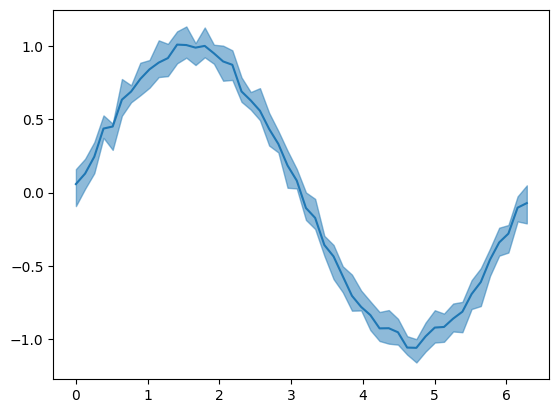

In [45]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = np.linspace(0, 2 * np.pi, 50)
y = np.sin(x) + np.random.randn(len(x)) * 0.03

yerr0 = y - (0.1 + np.random.randn(len(x)) * 0.03)
yerr1 = y + (0.1 + np.random.randn(len(x)) * 0.03)

ax.plot(x, y, color='C0')
plt.fill_between(x, yerr0, yerr1, color='C0', alpha=0.5)

In [62]:
fig = go.Figure()
list_color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

dir = './experiment/2023-03-22/'
for idx, folder in enumerate(os.listdir(dir)):
    with open(os.path.join(dir, folder, 'testing_log.json'), 'r') as fi:
        testing_log = json.load(fi)
        
    x_test = np.array(list(testing_log['accs'].keys()), dtype=np.int16)
    y_test = np.array([testing_log['accs'][key] * 100 for key in testing_log['accs'].keys()])
    std_test = np.array([testing_log['std_accs'][key] * 100 for key in testing_log['std_accs'].keys()])

    fig.add_trace(
        go.Scatter(
            x = np.concatenate([x_test, x_test[::-1]]),
            y = np.concatenate([y_test+std_test, (y_test-std_test)[::-1]]),
            fill = 'tozeroy',
            line=dict(
                width=0.1
            ),
            marker_color=list_color[idx],
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x = x_test,
            y = y_test,
            marker_color=list_color[idx]
        )
    )
    break
    
fig.update_layout(yaxis_range=[0,100])
fig.show()

{'global_epochs': 200, 'global_lr': None, 'local_epochs': 2, 'local_lr': 0.001, 'dataset': 'mnist', 'model': 'mnist', 'algorithm': 'fed_avg', 'clients_per_round': 5, 'lambda_': 100.0, 'cg_step': 5, 'note': 'fed_avg bản visualize'}
dict_keys(['losses', 'std_losses', 'accs', 'std_accs'])


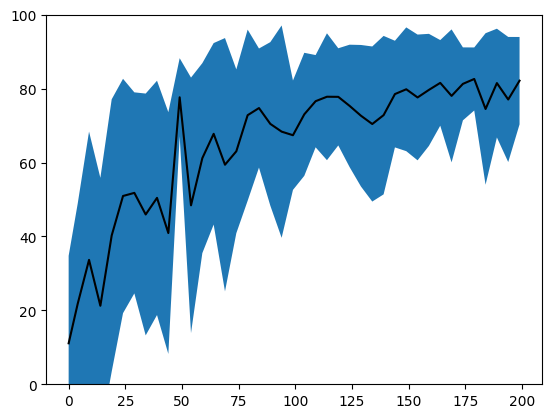

{'global_epochs': 200, 'global_lr': 0.001, 'local_epochs': 2, 'local_lr': 0.001, 'dataset': 'mnist', 'model': 'mnist', 'algorithm': 'fed_maml', 'clients_per_round': 5, 'lambda_': 100.0, 'cg_step': 5, 'note': 'fed_maml bản visualize'}
dict_keys(['losses', 'std_losses', 'accs', 'std_accs'])


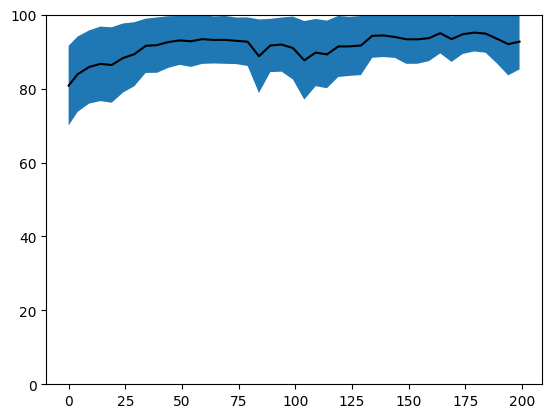

{'global_epochs': 200, 'global_lr': 0.001, 'local_epochs': 2, 'local_lr': 0.001, 'dataset': 'mnist', 'model': 'mnist', 'algorithm': 'fed_imaml', 'clients_per_round': 5, 'lambda_': 100.0, 'cg_step': 5, 'note': 'fed_imaml bản visualize'}
dict_keys(['losses', 'std_losses', 'accs', 'std_accs'])


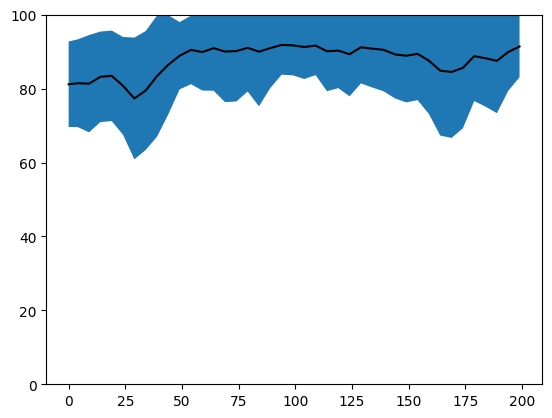

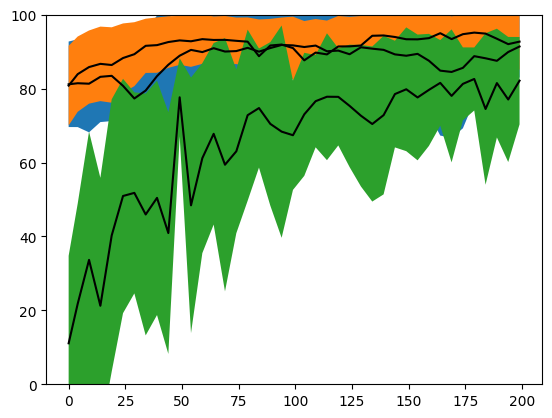

In [3]:
def vis(dir):
    with open(os.path.join(dir, 'description.json'), 'r') as fi:
        command = json.load(fi)

    with open(os.path.join(dir, 'testing_log.json'), 'r') as fi:
        testing_log = json.load(fi)

    print(command)
    print(testing_log.keys())
    
    x_test = np.array(list(testing_log['accs'].keys()), dtype=np.int16)
    y_test = np.array([testing_log['accs'][key] * 100 for key in testing_log['accs'].keys()])
    std_test = np.array([testing_log['std_accs'][key] * 100 for key in testing_log['std_accs'].keys()])
    
    plt.plot(x_test, y_test, 'k-')
    plt.fill_between(x_test, y_test-std_test, y_test+std_test)
    plt.ylim([0,100])
    
    plt.show()
    
# fed avg
vis('./experiment/2023-03-22/11:16/')

# maml
vis('./experiment/2023-03-22/11:17/')

# imaml
vis('./experiment/2023-03-22/11:19/')

dir = './experiment/2023-03-22/'
for folder in os.listdir(dir):
    with open(os.path.join(dir, folder, 'description.json'), 'r') as fi:
        command = json.load(fi)

    with open(os.path.join(dir, folder, 'testing_log.json'), 'r') as fi:
        testing_log = json.load(fi)
        
    x_test = np.array(list(testing_log['accs'].keys()), dtype=np.int16)
    y_test = np.array([testing_log['accs'][key] * 100 for key in testing_log['accs'].keys()])
    std_test = np.array([testing_log['std_accs'][key] * 100 for key in testing_log['std_accs'].keys()])
    
    plt.plot(x_test, y_test, 'k-')
    plt.fill_between(x_test, y_test-std_test, y_test+std_test)
    plt.ylim([0,100])
    
plt.show()

## test meta model

In [8]:
import torch
from torch.utils.data import DataLoader
from src.data.mnist_loader import get_loader
from src.model.mnist_model import Mnist
import learn2learn as l2l
from copy import deepcopy

In [2]:
# data
support_loader = get_loader('./data/mnist/client_test/0_s.json')
query_loader = get_loader('./data/mnist/client_test/0_q.json')

In [9]:
# model
model = Mnist()
clone = deepcopy(model)
meta_model = l2l.algorithms.MAML(model=model, lr=0.1, first_order=False)

In [10]:
# opt + loss_fn
optimizer = torch.optim.SGD(meta_model.parameters(), 0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
def print_(models: list[torch.nn.Module]):
    for p, q in zip(models[0].parameters(), models[1].parameters()):
        print(p.data - q.data)

print_([model, meta_model])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [12]:
# outer loop
for i in range(10):
    outer_loss = 0
    learner = meta_model.clone()
    # inner loop: adapt model of task
    for j in range(2):
        for X, y in support_loader:
            pred = learner(X)
            loss = loss_fn(pred, y)
            learner.adapt(loss)
         
    # opt meta_model
    for X, y in query_loader:
        pred = learner(X)
        loss = loss_fn(pred, y)
        outer_loss += loss
        
    optimizer.zero_grad()
    outer_loss.backward()
    optimizer.step()

In [14]:
print_([model, meta_model])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [20]:
for p, q in zip(model_.parameters(), clone.parameters()):
    print(p.data - q.data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([-2.8524e-03,  2.8932e-03,  6.8556e-03,  5.9264e-03,  5.5404e-02,
         4.8297e-02,  2.9389e-02,  3.6792e-02,  4.8951e-02,  4.5502e-02,
         1.3473e-03,  3.8562e-03,  1.7215e-02, -1.7467e-03,  2.2902e-02,
         2.1014e-02, -1.1357e-03,  4.2917e-02, -6.2321e-03, -8.9830e-05,
        -4.1897e-03,  2.4373e-02, -6.6387e-03,  5.6307e-03, -3.9857e-03,
         4.1033e-02, -1.2642e-03, -2.6495e-03,  3.7540e-02, -3.2286e-03,
        -1.6950e-03,  3.2008e-02,  1.6977e-03, -2.6122e-03,  1.2271e-02,
        -1.9887e-03, -5.0550e-03,  1.7677e-02,  4.8926e-02,  4.3371e-02,
        -8.2763e-04,  1.1617e-02,  1.8162e-02,  1.1539e-02,  1.7918e-02,
        -3.1348e-03,  1.7156e-02,  3.2888e-02,  2.0004e-03,  1.0095e-02,
        -1.8453e

In [19]:
from copy import deepcopy

model_ = Mnist()
opt = torch.optim.SGD(model_.parameters(), lr=0.1)
clone = deepcopy(model_)

for p in clone.parameters():
    print(p)
    print()
    break

for j in range(20):
    for X, y in support_loader:
        pred = model_(X)
        loss = loss_fn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
for p in model_.parameters():
    print(p)
    print()
    break

Parameter containing:
tensor([[ 0.0080,  0.0234,  0.0205,  ..., -0.0286, -0.0046, -0.0123],
        [-0.0174, -0.0226,  0.0314,  ..., -0.0316,  0.0113, -0.0282],
        [ 0.0079, -0.0266,  0.0331,  ..., -0.0193, -0.0048, -0.0300],
        ...,
        [ 0.0226, -0.0223, -0.0219,  ..., -0.0210,  0.0329,  0.0051],
        [-0.0222,  0.0280,  0.0326,  ..., -0.0196,  0.0044,  0.0022],
        [ 0.0183,  0.0240,  0.0322,  ..., -0.0154,  0.0355, -0.0065]],
       requires_grad=True)

Parameter containing:
tensor([[ 0.0080,  0.0234,  0.0205,  ..., -0.0286, -0.0046, -0.0123],
        [-0.0174, -0.0226,  0.0314,  ..., -0.0316,  0.0113, -0.0282],
        [ 0.0079, -0.0266,  0.0331,  ..., -0.0193, -0.0048, -0.0300],
        ...,
        [ 0.0226, -0.0223, -0.0219,  ..., -0.0210,  0.0329,  0.0051],
        [-0.0222,  0.0280,  0.0326,  ..., -0.0196,  0.0044,  0.0022],
        [ 0.0183,  0.0240,  0.0322,  ..., -0.0154,  0.0355, -0.0065]],
       requires_grad=True)

